In [1]:
import sys
import itertools
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
# import wrf
from matplotlib import cm
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import select_months_ds
from statistical_tests import ttest_1samp_new
from plotter import draw_basemap

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load ar dates within region
region = 'gulf_of_mexico' ## 'san_juan' 'baja' 'gulf_of_mexico'
ar_varname = 'tARget'
fname = '../out/bbox_dates_{0}_{1}.csv'.format(region, ar_varname)
df = pd.read_csv(fname)
df['day'] = pd.to_datetime(df['datetime']).dt.normalize()
df = df.sort_values(by=['datetime'])
# df = df.set_index(pd.to_datetime(df['datetime'])) ## set daily values as index
ar_dates = df['day'].values
## create year month columns in dataframe 
# df['yearmonth'] = df.index.strftime("%Y%m")
new = df.drop_duplicates('day')
ar_dates = new['day'].values

In [4]:
new

,Unnamed: 0,datetime,day
455,5,2000-10-21 16:00:00,2000-10-21
285,1,2000-10-22 00:00:00,2000-10-22
163,19,2000-10-27 07:00:00,2000-10-27
146,2,2000-10-28 00:00:00,2000-10-28
563,25,2001-06-05 01:00:00,2001-06-05
...,...,...,...
364,30,2022-07-04 15:00:00,2022-07-04
397,81,2022-07-26 01:00:00,2022-07-26
621,165,2023-07-04 14:00:00,2023-07-04
344,66,2023-07-05 00:00:00,2023-07-05


In [5]:
def compute_horizontal_composites(varname, anomaly, ar_dates, ssn, region):
    ## function that computes composites (anomaly or non-anomaly) for defined start_mon and end_mon    
    ## for DJF, MAM, JJA, SON, NDJFMA, and MJJASON
    ## compute anomaly composites - anomaly = True
    ## compute non-anomaly composites - anomaly=False

    ## set start_mon and end_mon based on ssn
    if ssn == 'DJF':
        start_mon, end_mon = (12, 2)
    elif ssn == 'MAM':
        start_mon, end_mon = (3, 5)
    elif ssn == 'JJA':
        start_mon, end_mon = (6, 8)
    elif ssn == 'SON':
        start_mon, end_mon = (9, 11)
    elif ssn == 'NDJFMA':
        start_mon, end_mon = (11, 4)
    elif ssn == 'MJJASO':
        start_mon, end_mon = (5, 10)

    ## load data
    path_to_data = '/expanse/nfs/cw3e/cwp140/downloads/ERA5/'
    out_path = '/home/dnash/DATA/preprocessed/ERA5_composites/'
    
    if anomaly == True:
        fname_pattern = path_to_data + '{0}/anomalies/daily_filtered_anomalies_{0}_*.nc'.format(varname)
    else:
        fname_pattern = path_to_data + '{0}/daily/era5_namerica_025dg_daily_{0}_*.nc'.format(varname)

    ds = xr.open_mfdataset(fname_pattern, engine='netcdf4', combine='by_coords')

    ## subset to AR dates
    ds = ds.sel(time=ar_dates)

    ## subset to start_month and end_month
    ds = select_months_ds(ds, start_mon, end_mon, 'time')
    ds = ds.load()

    # ## run students t-test if anomaly == True
    # if anomaly == True:    
    #     popmean = np.zeros([len(ds.latitude), len(ds.longitude)]) ## population mean
    #     ndays = len(ds.time) # number of unique days
    #     print(ndays)
    #     # calculate t-value based on ndays
    #     a_mean, tval_mask = ttest_1samp_new(a=ds, popmean=popmean, dim='time', n=ndays)

    #     ## write to netCDF
    #     out_fname = out_path + '{0}/{2}/filtered_anomaly_composite_{0}_{1}.nc'.format(varname, ssn, region)
    #     a_mean.to_netcdf(path=out_fname, mode = 'w', format='NETCDF4')

    #     out_fname = out_path + '{0}/{2}/filtered_anomaly_composite_tvals_{0}_{1}.nc'.format(varname, ssn, region)
    #     tval_mask.to_netcdf(path=out_fname, mode = 'w', format='NETCDF4')

    # else:
    #     a_mean = ds.mean('time')
    #     out_fname = out_path + '{0}/{2}/composite_{0}_{1}.nc'.format(varname, ssn, region)
    #     a_mean.to_netcdf(path=out_fname, mode = 'w', format='NETCDF4')

    # return a_mean
    return ds

In [6]:
%%time
## iterate through options
varname_lst = ['700z', 'ivt']
ssn_lst = ['NDJFMA']
anom_lst = [False]

a = [varname_lst, ssn_lst, anom_lst]
ds_lst = []
option_lst = list(itertools.product(*a))
for i, lst in enumerate(option_lst):
    anomaly = lst[2]
    ssn = lst[1]
    varname = lst[0]
    print('Anomaly:', anomaly, 'Season:', ssn, 'Variable:', varname)
    tmp = compute_horizontal_composites(varname, anomaly, ar_dates, ssn, region)
    ds_lst.append(tmp)

Anomaly: False Season: NDJFMA Variable: 700z
Anomaly: False Season: NDJFMA Variable: ivt
CPU times: user 1.13 s, sys: 581 ms, total: 1.72 s
Wall time: 8.33 s


In [7]:
ds = xr.merge(ds_lst)
ds

<xarray.Dataset>
Dimensions:    (longitude: 401, latitude: 201, time: 3)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.8 -169.5 ... -70.5 -70.25 -70.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 10.5 10.25 10.0
  * time       (time) datetime64[ns] 2007-03-22 2010-03-07 2019-03-10
Data variables:
    z          (time, latitude, longitude) float32 2.6e+04 ... 3.094e+04
    ivtv       (time, latitude, longitude) float32 -5.064 -5.173 ... 84.56 121.4
    ivtu       (time, latitude, longitude) float32 14.64 14.5 ... -126.5 -142.1
    ivt        (time, latitude, longitude) float32 16.17 16.17 ... 154.2 188.2
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-10 18:32:43 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [8]:
## create tick labels 'YYYY-MM-DD HH'
t_lst = []
for m, start_date_val in enumerate(ds.time.values):
    ts = pd.to_datetime(str(start_date_val)) 
    t = ts.strftime('%Y-%m-%d')
    t_lst.append(t)
# ["{:.0%}".format(i) for i in cbax.get_ticks()]
t_lst

['2007-03-22', '2010-03-07', '2019-03-10']

In [9]:
# Set up projection
# mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()
ext = [-140., -90., 20, 50]

# Set tick/grid locations
lats = ds.latitude.values
lons = ds.longitude.values
dx = np.arange(lons.min().round(),lons.max().round()+20,20)
dy = np.arange(lats.min().round(),lats.max().round()+10,10)

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

261.38696 321.02887
259.53912 318.94745
248.95589 320.031


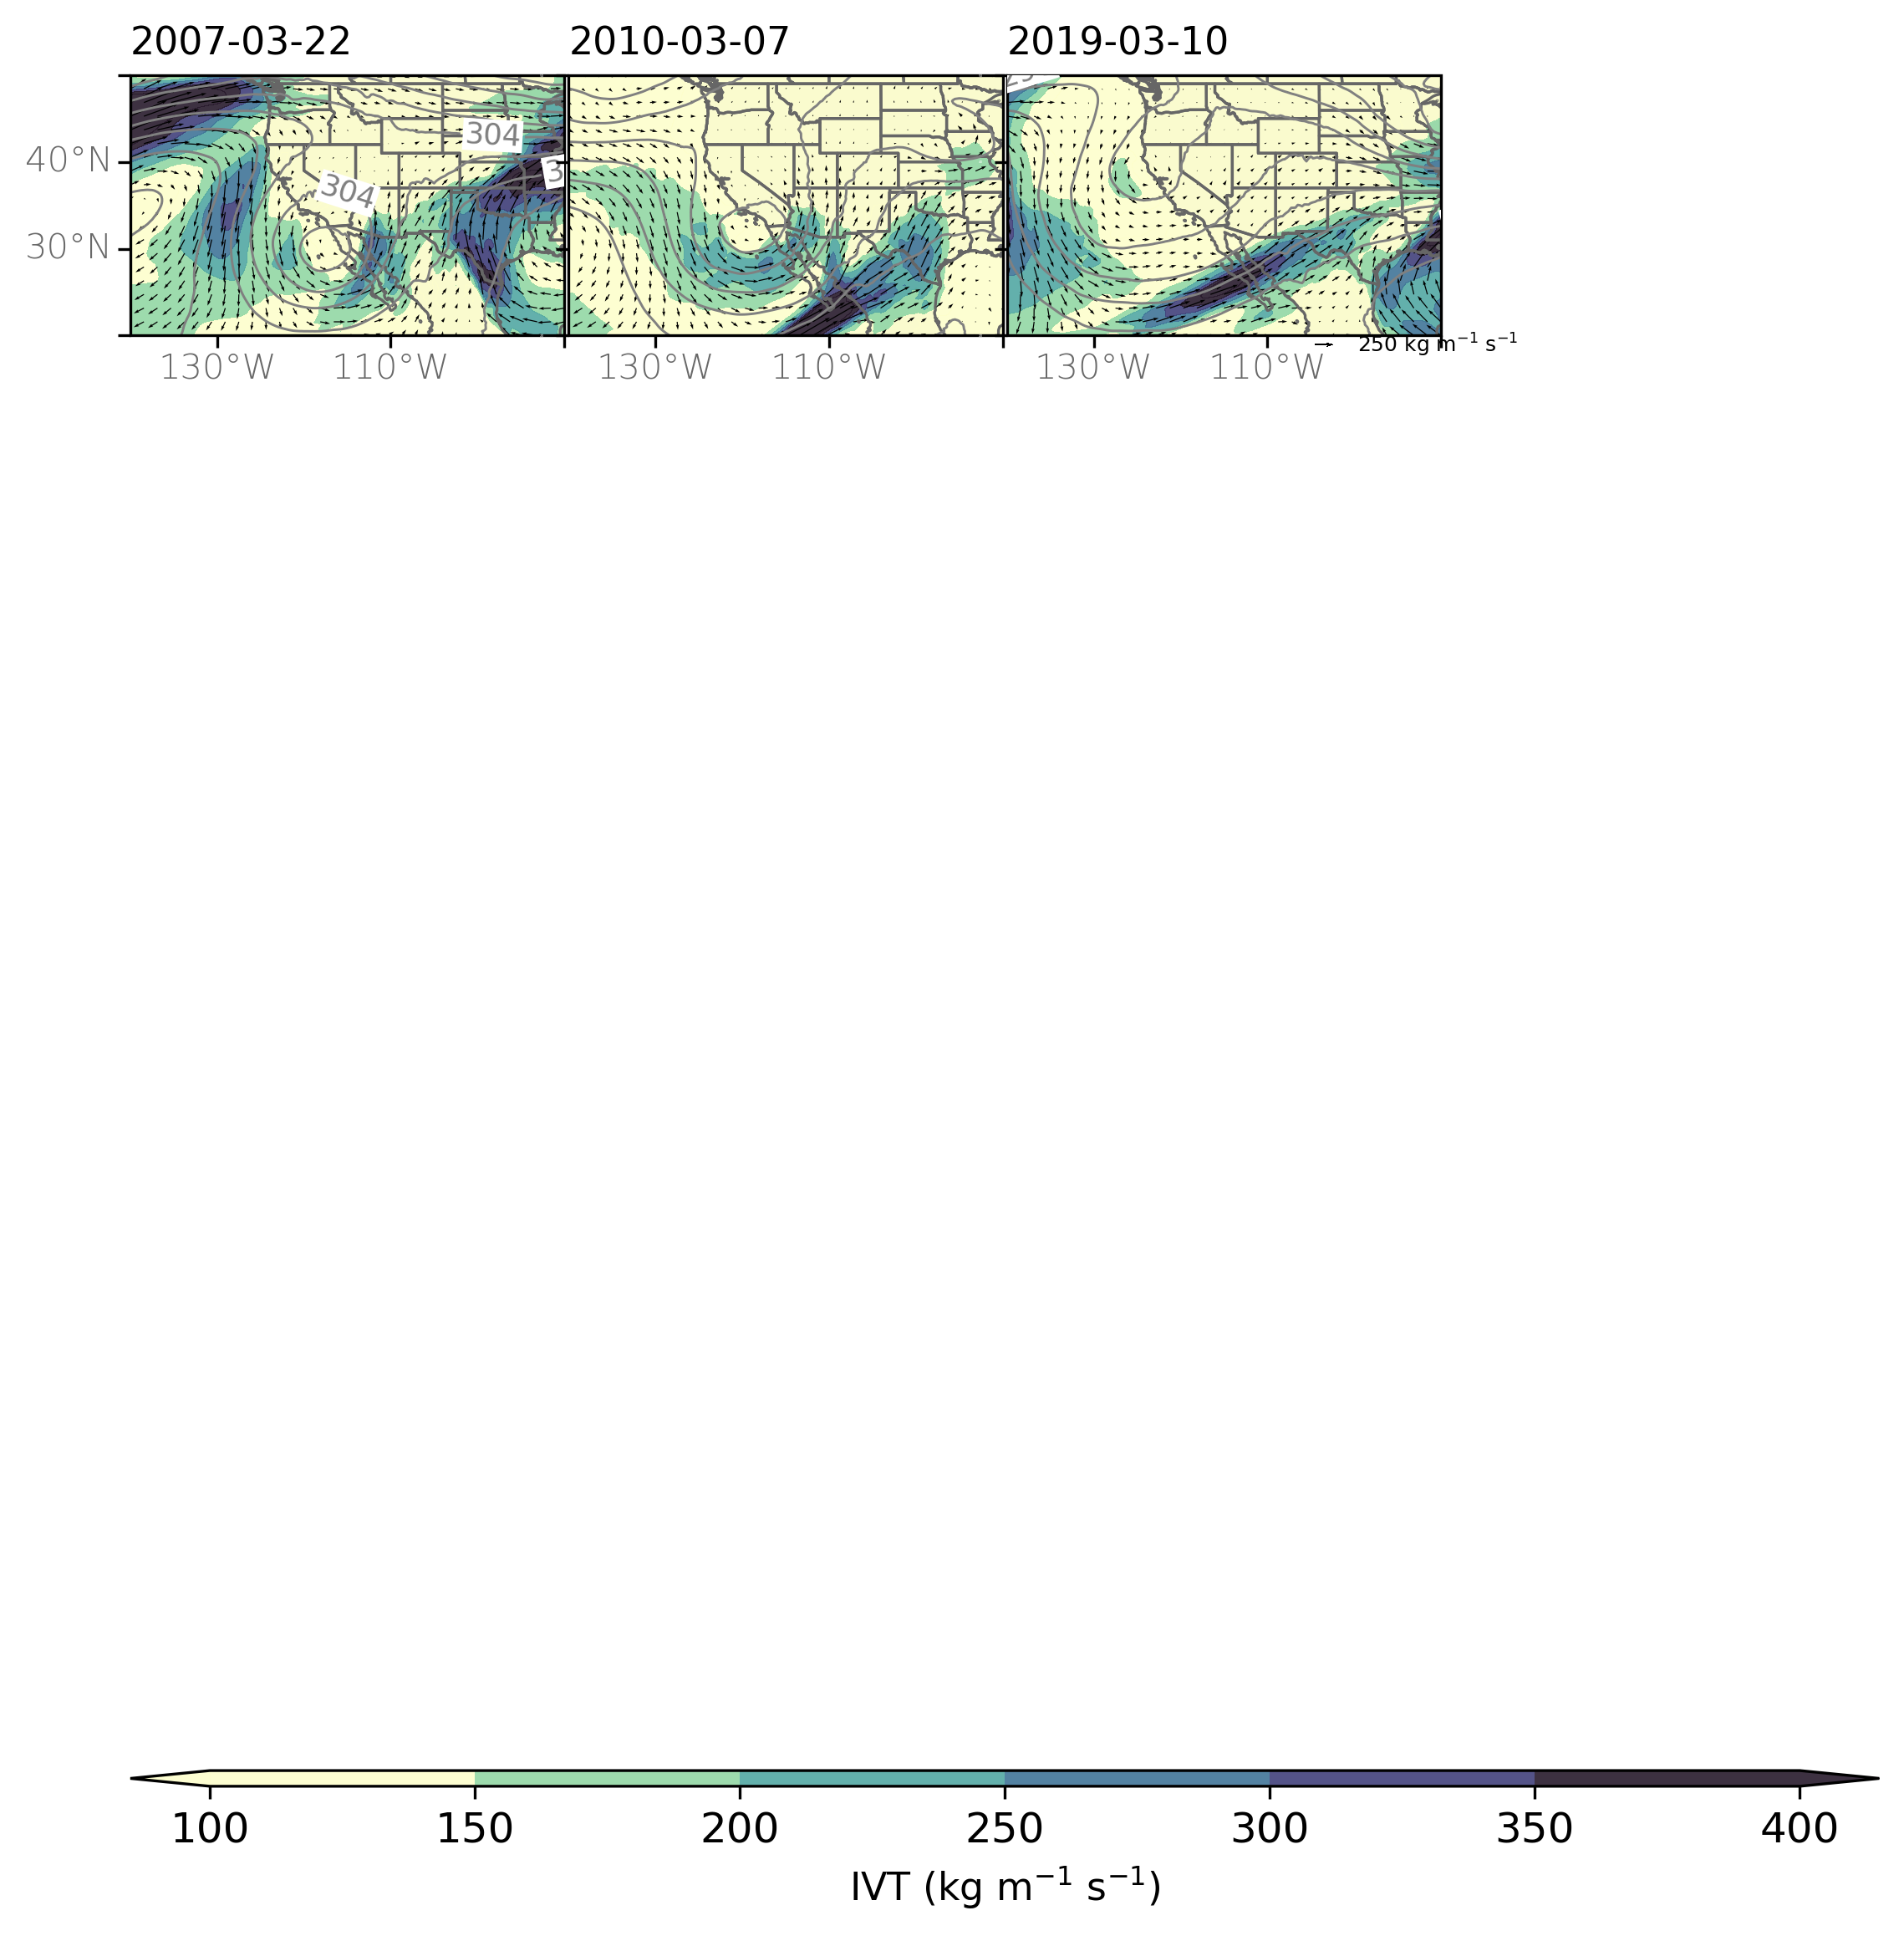

In [10]:
##### Create figure
fig = plt.figure(figsize=(9, 9))
fig.dpi = 300
fname = path_to_figs + '{0}_IVT_700z_synoptic_test_{1}'.format(region, anom_lst[0])
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 7
ncols = 4

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1, 1, 0.05, 0.05], width_ratios = [1, 1, 1, 1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

#################
### COMPOSITE ###
#################

# rowidx = [0]*4 + [1]*4 + [2]*4 + [3]*4 + [4]*4
# colidx = [0, 1, 2, 3]*5
# llats = [True, False, False, False]*5
# blons = [False, False, False, False]*4 + [True, True, True, True]
rowidx = [0]*3
colidx = [0, 1, 2]
llats = [True, False, False]
blons = [True, True, True]
for i, (row, col) in enumerate(zip(rowidx, colidx)):
    tmp = ds.isel(time=i)
    ax = fig.add_subplot(gs[row, col], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=llats[i], right_lats=False, bottom_lons=blons[i])
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    
    # Contour Filled
    lats = tmp.latitude.values
    lons = tmp.longitude.values
    ivt = tmp.ivt.values
    if anom_lst[0] == False:
        cflevs = np.arange(100, 450, 50) # levels for IVT
        cmap = cmo.deep # cmap for IVT
        clevs = np.arange(0, 1280, 4) # levels for 700z
    elif anom_lst[0] == True:
        cmap = cm.BrBG
        cflevs = np.arange(-150., 175., 25)
        clevs = np.arange(-48, 52, 4)
        
    norm = mcolors.BoundaryNorm(cflevs, cmap.N)
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, norm=norm, alpha=0.9, extend='both')

    # Wind barbs / vectors 
    uvec = tmp.ivtu.values
    vvec = tmp.ivtv.values
    # uvec_mask = ds.IVTu.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
    # vvec_mask = ds.IVTv.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # Contour Lines
    hgts = tmp.z.values/9.80665 ## convert to geopotential height
    hgts = hgts/(10) # convert to meters # 750-hPa Heights
    print(hgts.min(), hgts.max())
    
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    
    kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i', 'rightside_up': True, 'use_clabeltext': True}
    cl = ax.clabel(cs, clevs[::2], **kw_clabels)
    for txt in cl:
                txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0.5))

    ax.set_title(t_lst[i], loc='left', fontsize=11)
    # titlestring = '({0}) {1}'.format(letter_lst[i], ssn)
    # ax.text(0.02, 0.97, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)


# quiver key
qk = ax.quiverkey(Q, 0.75, -0.035, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 6.0})
# Colorbar (single)
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cb = fig.colorbar(cf, cbax, orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()